In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from scipy.stats import norm
import scipy as sp
from scipy.integrate import odeint,quad,simps,trapz
from scipy.special import eval_hermite,eval_hermitenorm
from math import sqrt,sin,pi,cos,exp,log,factorial

# Estimation of the operator $\mathcal{L}$

### 0. Data Simulation Euler–Maruyama method

$$V(x) = \frac{5}{6}x^6 - \frac{5}{2}x^4$$

\begin{align}
dX_t &= -\nabla V(X_t)dt + \sqrt{2D}dW_t \\
dX_t &= (-5X_t^5 +10X_t^3)dt + \sqrt{2D}dW_t \\
X_0 &= 0 \\
\end{align}

In [2]:
def DWSimulation(x0, n,dt,D):
    """
    Function to create the trayectory of a OU process
    with difussion paramter D 

    :param x0: Intial position
    :param n:  Number of steps
    "param dt: Step size
    :param D:  Difussion parameter

    :return X: Trajectory
    """
    t = np.linspace(x0,dt*n,n)
    X = np.zeros(n)
    noise = np.random.normal(loc=0,scale=np.sqrt(dt),size=n)
    for i in range(1,n):
        x = X[i-1]
        X[i] = x + (-5*x**5 + 10*x**3)*dt +sqrt(2*D) * noise[i]
    return(X)

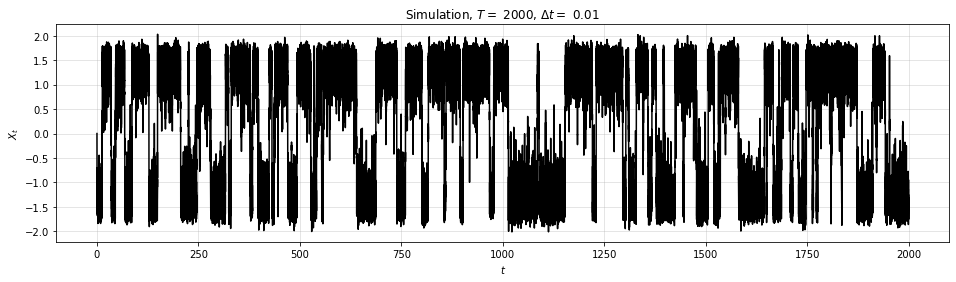

In [3]:
x0 = 0
n = 200000
dt = 0.01
T = dt*n
D = 1
np.random.seed(1)
X = DWSimulation(x0,n,dt,D)
V = lambda x:  (5/6)*x**6 - (5/2)*x**4
DV = lambda x:  5*x**5 - 10*x**3
_ = plt.figure(figsize=(16,4))
_ = plt.plot(np.linspace(x0,n*dt,n), X,color='black')
_ = plt.grid(alpha=0.4)
_ = plt.xlabel("$t$")
_ = plt.ylabel("$X_t$")
_ = plt.title(f"Simulation, $T=$ {T:.0f}, $\Delta t =$ {dt}")

In [4]:
N = 2000
X_s = X[np.random.choice(range(n),size=N)]

### 1. Compute an estimation of the invariant distribution of $\{x_i\}_{i=1}^{N}$, we denote it by $\hat{\rho}_{\text{eq}}$, we can do it by a non-parametric method such as kernel estimation.

$$p(x) = \frac{1}{Z} \exp\left(\frac{\frac{5}{2}x^4  -  \frac{5}{6}x^6}{D} \right)$$
\begin{align}
\end{align}

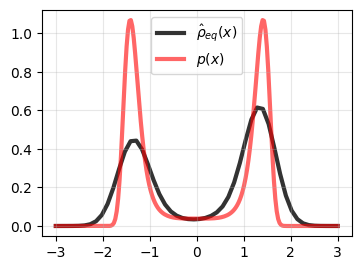

In [5]:
g_kde  = sp.stats.gaussian_kde(X_s)
rho_eq = np.vectorize(lambda x:g_kde(x)[0] )
Z  = simps(x = np.linspace(-10,10,2000), y = [np.exp(-V(x)/(D)) for x in np.linspace(-10,10,2000)])
p_invariant = np.vectorize(lambda x:  (1/(Z))*np.exp(-V(x)/(D)))
_ = plt.figure(figsize=(4,3),dpi=100)
_ = plt.plot(np.linspace(-3,3),[rho_eq(x) for x in np.linspace(-3,3)],
             color='black',lw=3,zorder=1,alpha=0.8,label='$\\hat{\\rho}_{eq}(x)$')
_ = plt.plot(np.linspace(-3,3,200),[p_invariant(x) for x in np.linspace(-3,3,200)],
             color='r',lw=3,zorder=1,alpha=0.6,label='$p(x)$')
_ = plt.legend()
_ = plt.grid(alpha=0.3,zorder=1)

### 2. Compute an estimate $\rho = \hat{\rho}_{\text{eq}}^{-1/2}$

In [6]:
rho = np.vectorize(lambda x: rho_eq(x)**(-0.5))
Rho = rho(X_s).reshape(1,N)

### 3. Estimate $\epsilon$ computing $T(\epsilon) =\frac{1}{N}\sum_{i,j=1}^N K_\epsilon(x_i,x_j)$ and the derivatives to compute $$\epsilon = \text{argmax}_\epsilon \frac{\log(T(\epsilon + h) - \log(T(\epsilon))}{\log(\epsilon+h) - \log(\epsilon)}$$

In [7]:
Norm = np.zeros((N,N))
for i in range(N):
    Norm[i,:] = -(X_s - X_s[i])**2
Norm /= 4 *(Rho.T @ Rho)

In [8]:
h = 1e-6 #Small perturbation for T 
T = lambda epsilon : (1/N**2)*np.exp(Norm / epsilon).sum()
val = []

for l in np.linspace(-20,2): #evaluate for valyes from 2^-30 to 2 
    e = 2**l
    val.append((log(T(h+e)) - log(T(e))) / (log(e+h) - log(e)))

epsilon = 2 **np.linspace(-20,2)[np.argmax(val)]
epsilon

0.0001892594634988658

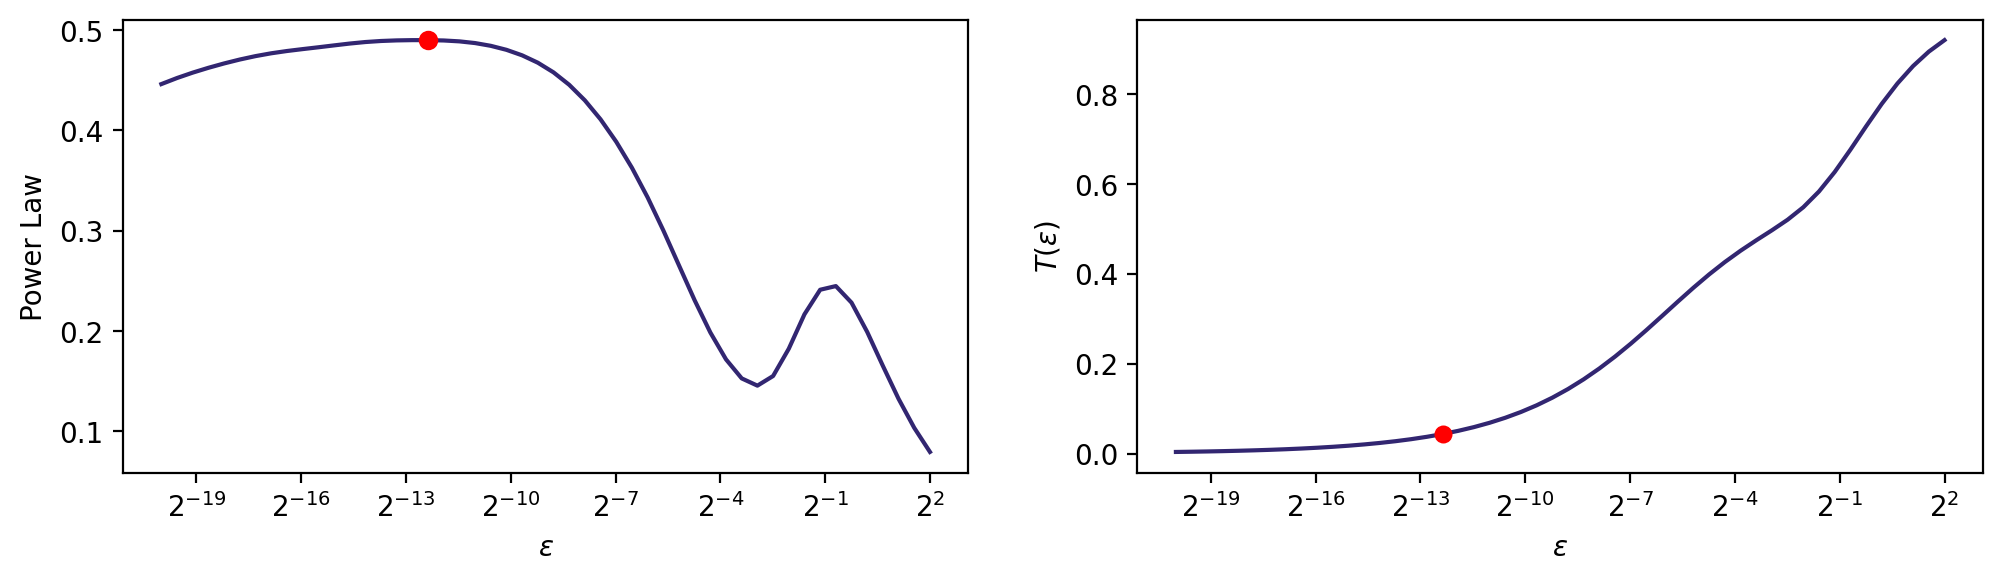

In [9]:
fig,axs = plt.subplots(1,2,figsize=(12,3),dpi=200)

axs[0].plot(2**np.linspace(-20,2),val,zorder=1,color='#322671')
axs[0].scatter(epsilon,max(val),color='red',zorder=2)

axs[0].set_xlabel('$\epsilon$')
axs[0].set_ylabel('Power Law')
axs[0].set_xscale('log',base=2)

axs[1].plot(2**np.linspace(-20,2), [T(2**l) for l in np.linspace(-20,2)],zorder=1,color='#322671')
axs[1].scatter(epsilon,T(epsilon),s=30,color='red',zorder=2)
axs[1].set_xlabel('$\epsilon$')
axs[1].set_ylabel('$T(\epsilon)$')
axs[1].set_xscale('log',base=2)

### 4. Compute the intrinsic dimension $d$ of the maifold $\mathcal{M}$ given by the data $\{x_i\}_{i=1}^{N}$, $d = 2\max_\epsilon \frac{\log(T(\epsilon + h) - \log(T(\epsilon))}{\log(\epsilon+h) - \log(\epsilon)}$

In [10]:
d = 2 * (log(T(h+epsilon)) - log(T(epsilon))) / (log(epsilon+h) - log(epsilon))
d

0.9801995851619592

### 5. Compute the normalization kernel from the observations $$K_{\epsilon,\alpha}(x_i,x_j) = \frac{K_{\epsilon}(x_i,x_j)}{q_\epsilon(x_i)^\alpha q_\epsilon(x_j)^\alpha} $$ where $q_\epsilon(x) = \sum_{j=1}^N \frac{K_\epsilon(x,x_j)}{\rho(x)^d}$ and $\alpha = -d/4$

In [11]:
alpha = - d / 4
K_e = np.exp(Norm/epsilon)
q_e = (K_e.sum(axis=1) / (Rho ** d)).reshape(N,1)
K_e_a = K_e/((q_e**alpha)@ (q_e** alpha).T)

### 6. Compute the matrix estimation of $D^{-1}\mathcal{L}$, $L_\epsilon$

$$\hat{L}_\epsilon(x_i,x_j) = \frac{1}{\epsilon\rho(x_i)\rho(x_j)}\left (\frac{K_{\epsilon,\alpha}(x_i,x_j)}{\sqrt{q_{\epsilon,\alpha}(x_i)q_{\epsilon,\alpha}(x_j)}}-\delta_{ij} \right)$$

In [12]:
I = np.identity(N)
q_e_a = K_e_a.sum(axis=1)
Dii = np.diag(q_e_a)
Pii = np.diag(Rho[0,:])
Sii = Pii @ np.sqrt(Dii)
S_1 = np.diag(1/np.diag(Sii))
L_hat = (1/epsilon) * (S_1 @ K_e_a @ S_1 - np.diag(1/(np.diag(Pii)**2)))
L_e = (1/epsilon) *np.diag(1/(np.diag(Pii)**2)) @ (np.diag(1/(np.diag(Dii))) @ K_e_a - I)

### 7. Compute the eigenvectors of $\hat{L}_\epsilon$ to get the eigenvectors of $L_\epsilon$ 

In [13]:
M = 500
l, U = sp.linalg.eigh(L_hat,subset_by_index =(N-M,N-1),turbo=False)
l = l[::-1]
U = U[:,::-1]

In [14]:
phi = S_1 @ U 
phi = phi / np.linalg.norm(phi,axis=0) * np.sqrt(N)
phi_1 = np.linalg.pinv(phi)

Text(0.5, 1.0, 'Eigenvectors')

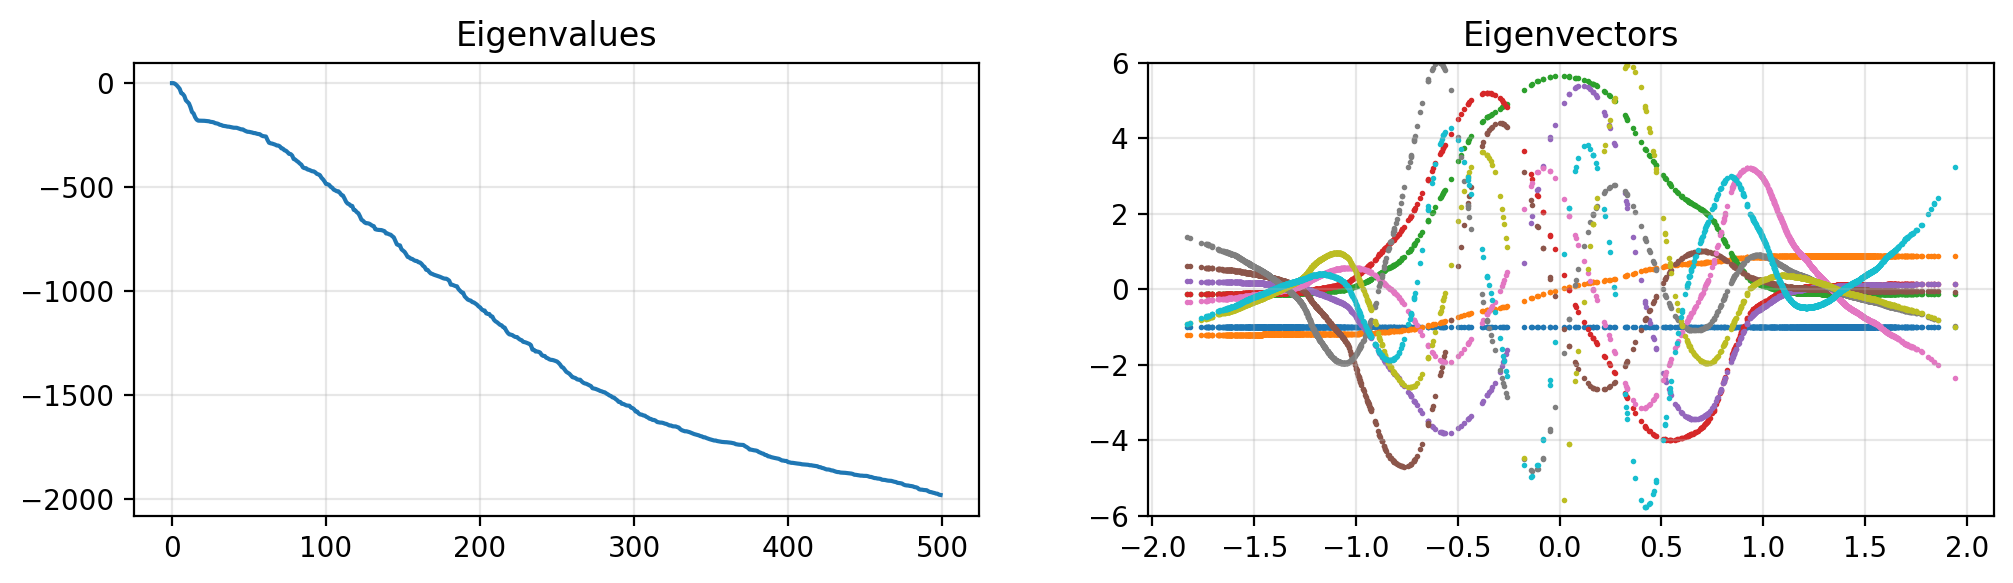

In [15]:
fig,axs = plt.subplots(1,2,figsize=(12,3),dpi=200)
axs[0].plot(l)
axs[0].set_title('Eigenvalues')
axs[0].grid(alpha=0.3)

for i in range(10):
    axs[1].scatter(X_s,phi[:,i],s=1)
axs[1].grid(alpha=0.3)
axs[1].set_ylim(-6,6)
axs[1].set_title('Eigenvectors')

\begin{align}
\mathcal{L} & = D \Delta - \nabla V \cdot \nabla \\
& = D \Delta - \left(\frac{5}{6}x^6 - \frac{5}{2}x^4 \right)\nabla\\
\mathcal{L}\cos(x) &= -D\cos(x) + \left(\frac{5}{6}x^6 - \frac{5}{2}x^4 \right) \sin(x)
\end{align}



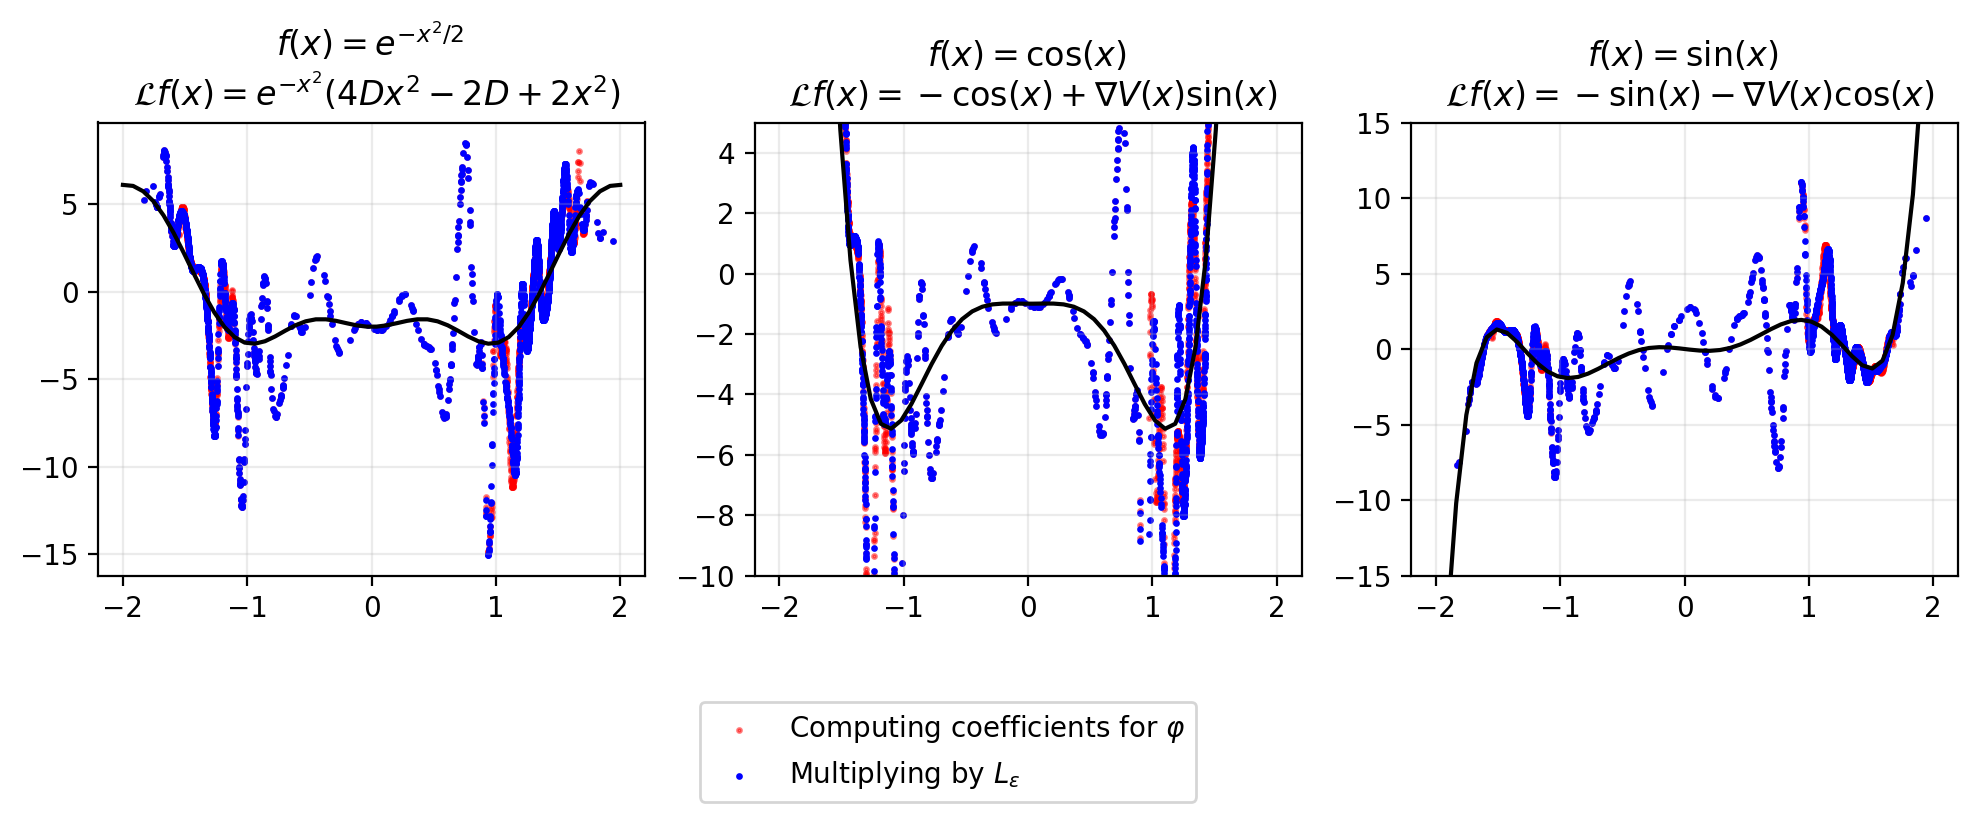

In [16]:
fig,axs = plt.subplots(1,3,figsize=(12,3),dpi=200)

x = np.linspace(-2,2)

Y = np.exp(-X_s**2)
c_coef = (D*phi_1@Y)
axs[0].set_title("$f(x) =e^{-x^2/2} $ \n $\mathcal{L}f(x) = e^{-x^2}(4Dx^2-2D + 2x^2) $")
axs[0].plot(x, D*np.exp(-x**2)*(4*x**2-2) + DV(x)*2*x*np.exp(-x**2),color='k')
axs[0].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',alpha=0.5)
axs[0].scatter(X_s,D*L_e@Y,s=2,color='b')
axs[0].grid(alpha=0.25)
Y = np.cos(X_s)
c_coef = (D*phi_1@Y)
axs[1].set_title("$f(x) =\cos(x) $ \n $\mathcal{L}f(x) = -\cos(x)+\\nabla V(x)\sin(x) $")
axs[1].plot(x,-D*np.cos(x) + DV(x) * np.sin(x),color='k')
axs[1].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',alpha=0.5)
axs[1].scatter(X_s,D*L_e@Y,s=2,color='b')
axs[1].grid(alpha=0.25)
axs[1].set_ylim(-10,5)

Y = np.sin(X_s)
c_coef = (D*phi_1@Y)
axs[2].set_title("$f(x) =\sin(x) $ \n $\mathcal{L}f(x) = -\sin(x)-\\nabla V(x)\cos(x) $")
axs[2].plot(x,-D*np.sin(x) - DV(x) * np.cos(x),color='k')
axs[2].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',label='Computing coefficients for $\\varphi$',alpha=0.5)
axs[2].scatter(X_s,D*L_e@Y,s=2,color='b',label='Multiplying by $L_{\epsilon}$')

axs[2].grid(alpha=0.25)
axs[2].set_ylim(-15,15)
axs[2].legend(loc=(-1.3,-0.5))

### 9. Compute a one dimensional observable $S$, for example $S(x(t)) = \sum_{i=1}^{n}((x(t))_i - \mathbb{E}((x(t))_i) $

In [17]:
S = (X - X.mean())

### 10. Estimate the correlation time $$T_c = \int_{0}^{\infty} C(\tau)C(0)^{-1}d\tau \approx \text{(TR)}\int\frac{1}{T-j}\sum_{i=1}^{T-j}S(x_{i+j})S(x_i) $$

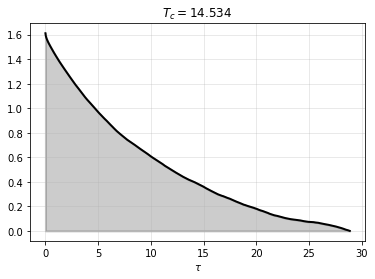

In [18]:
T = n
height=[]
for j in range(1,T):
    inte = 1/(T-j)*sum(S[:T-j]*S[j:])
    if inte<0:
        break
    else:
        height.append(inte)
    
Tc = simps(x=np.linspace(0,n*dt,n)[:len(height)],y=height)

_ = plt.grid(alpha=0.35)
_ = plt.plot(np.linspace(0,n*dt,n)[:len(height)],height,color='k',lw=2)
_ = plt.fill_between(np.linspace(0,n*dt,n)[:len(height)],height,color='k',lw=2,alpha=0.2)
_ = plt.xlabel('$\\tau$')
_ = plt.title(f'$T_c = {Tc:.3f}$')

 ### 11. Estimate D as $$D = -\frac{1}{T_c}\frac{\sum_{i=1}^M \lambda_i ^{-1}(S(x)^{\top}\varphi_i)^2}{\sum_{i=1}^M (S(x)^{\top}\varphi_i)^2} $$

In [ ]:
S = (X_s - X_s.mean())
s1 = np.sum((1/l[1:]) * (S.T@phi[:,1:])**2)
s2 = np.sum((S.T@phi[:,1:])**2)
D = - (1/Tc) * (s1/s2)
D

# Push-forward of a initial density $p_0(x)$

### 1. Estimate the initial condition $c_i(0)$ as $$\hat{c}_i(0)=\frac{1}{N}\sum_{j=1}^N \frac{p_0(x_j)}{\hat{p}_{\text{eq}}(x_j)}\varphi_i(x_j) $$

In [128]:
p_0 = np.vectorize(lambda x: sp.stats.norm.pdf(x,0,0.3))

p_inf = p_invariant
c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s)))[:,None] * U,axis=0)

### 2. Compute the numerical solution of the ODE $$\frac{\text{d} c}{\text{d} t} = D\Lambda c$$ with initial condition $\hat{c}_i(0)$

In [129]:
Lambda = np.diag(l)
D = 1
def RHS(y,t):
    return((D*Lambda) @ y)

init = 0
tf = 1
Nt = 200
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,c_0,tarray,args=())

### 3. Using $M$ modes estimate the density  as $$\hat{p}(x,t) =\hat{p}_{\text{eq}}(x) \sum_{i=0}^M \hat{c}_i(t)\varphi_i(x)$$

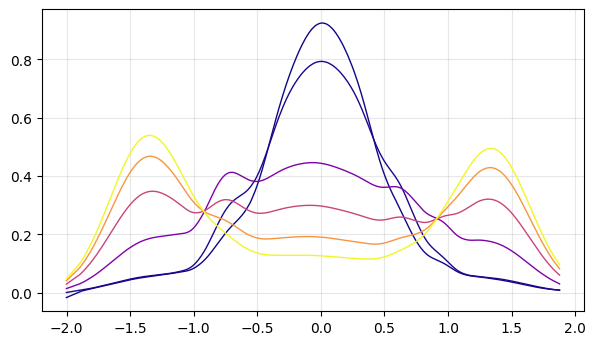

In [130]:
_ = plt.figure(figsize=(7,4),dpi=100)
X_sort = np.sort(X_s)
N = len(X_s)
dx = np.diff(X_sort)
for t in [1,5,50,99,150,199]:
    est_density = np.zeros(N,)
    for i in range(N):
        est_density[i] = np.sum(csol[t] * phi[i,:] * rho_eq (X_s[i]))

    est_density=est_density[np.argsort(X_s)]
    cum = trapz(x=X_sort,y= est_density)
    
    plt.plot(X_sort,(1/cum) *est_density,lw=1,color=plt.cm.plasma(t/200))
    
# plt.plot(np.linspace(min(X_s),max(X_s),100),p_inf(np.linspace(min(X_s),max(X_s),100)),
#          color='r',marker='x',ms=5,alpha=0.5)
# plt.plot(np.linspace(min(X_s),max(X_s),100),p_0(np.linspace(min(X_s),max(X_s),100)),
#          color='k',marker='x',ms=5,alpha=0.7)
    
plt.grid(alpha=0.3)

In [ ]:
_ = plt.figure(figsize=(7,4),dpi=100)
X_sort = np.sort(X_s)
N = len(X_s)
dx = np.diff(X_sort)
for t in range(200):
    est_density = np.zeros(N,)
    for i in range(N):
        est_density[i] = np.sum(csol[t] * phi[i,:] * rho_eq (X_s[i]))
    est_density=est_density[np.argsort(X_s)]
    cum = trapz(x=X_sort,y= est_density)
    
    plt.plot(X_sort,(1/cum) *est_density,lw=1,color=plt.cm.plasma(t/200))

    
plt.grid(alpha=0.3)

# Push-forward of obserbable $f(x)$


In [ ]:
Lambda = np.diag(l)
D = 1
def RHS(y,t):
    return((D*Lambda) @ y)

init = 0
tf = 5
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,c_0,tarray,args=())

In [ ]:
for p in [1,2,3,4]:
    N = len(X_s)
    f = X_s**p
    a = (1/N)*(f @ phi)
    plt.plot(csol @ a)